In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
datapath = "./data/"
files = os.listdir(datapath)

sensor_names = ["Deflection", "Load", "Vibration", "SurfaceFinish"]

def load_data(sensor_name):
    if sensor_name not in sensor_names:
        print("Sensor name not found")
        return None
    for file in files:
        if sensor_name in file:
            data = pd.read_csv(datapath + file)
            return data
    print("File not found")
    return None

df = {}
for sensor_name in sensor_names:
    df[sensor_name] = load_data(sensor_name)
    


In [3]:
deflection = df["Deflection"]
load = df["Load"]
vibration = df["Vibration"]
surface_finish = df["SurfaceFinish"]


In [4]:
deflection.shape, load.shape, vibration.shape, surface_finish.shape

((2019, 2), (2019, 2), (1385, 2), (1385, 2))

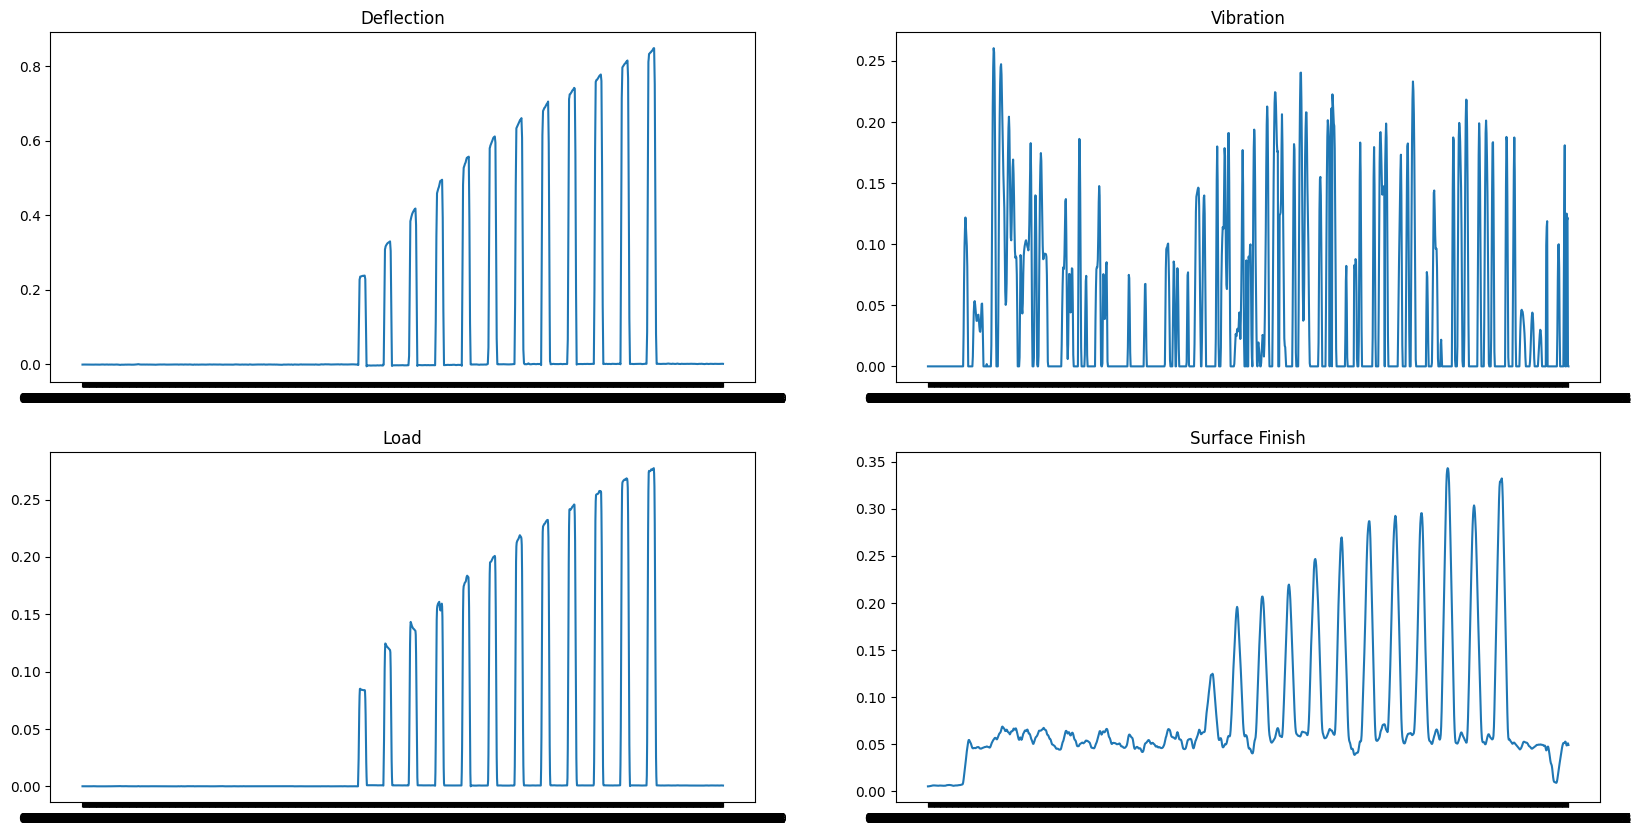

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(deflection["Time"], deflection["Value"])
plt.title("Deflection")
plt.subplot(2, 2, 3)
plt.plot(load["Time"], load["Value"])
plt.title("Load")
plt.subplot(2, 2, 2)
plt.plot(vibration["Time"], vibration["Value"])
plt.title("Vibration")
plt.subplot(2, 2, 4)
plt.plot(surface_finish["Time"], surface_finish["Value"])
plt.title("Surface Finish")
plt.show()

In [6]:
data = surface_finish["Value"].values
data[900:1000] += .5
dataT = torch.tensor(data, dtype=torch.float32)

X shape:  torch.Size([1365, 20])


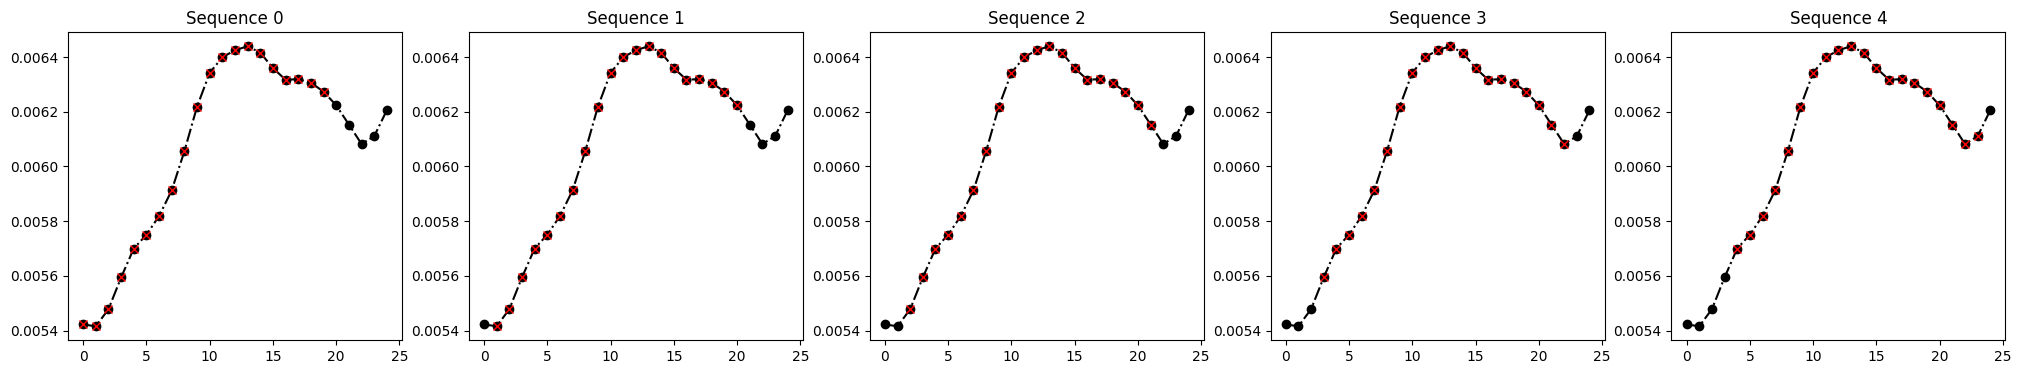

In [7]:
def create_sequences(data, window):
    x = []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
    return torch.stack(x)

window = 20
x = create_sequences(dataT, window)

print("X shape: ", x.shape)

plt.figure(figsize=(25, 4))
for i in range(5): 
    plt.subplot(1, 5, i+1)
    plt.plot(data[:window + 5], 'ko-.')
    plt.plot(range(i, i+window), x[i].numpy(), 'rx')
    plt.title(f"Sequence {i}")

plt.show()


In [8]:
class Encoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=1, 
            hidden_size=256, 
            num_layers=1, 
            batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size=256, 
            hidden_size=16, 
            num_layers=1, 
            batch_first=True
        )
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm1(x)
        x, (hidden, cell) = self.lstm2(x)
        return x
    
class Decoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=16, 
            hidden_size=256, 
            num_layers=1, 
            batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size=256, 
            hidden_size=1, 
            num_layers=1, 
            batch_first=True
        )
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        x, (hidden, cell) = self.lstm1(x)
        x, (hidden, cell) = self.lstm2(x)
        x = self.fc(x)
        return x

class LSTMAutoEncoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
model = LSTMAutoEncoder().to(device)
model

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 16, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(16, 256, batch_first=True)
    (lstm2): LSTM(256, 1, batch_first=True)
    (fc): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [10]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_size = int(.5 * len(x))
test_size = len(x) - train_size

train_data = x[:train_size]
test_data = x[train_size:]

train_data.shape, test_data.shape

(torch.Size([682, 20]), torch.Size([683, 20]))

In [11]:
def train(model, train_data, test_data, optimizer, loss_fn, epochs=100):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = loss_fn(output, train_data)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        model.eval()
        with torch.no_grad():
            output = model(test_data)
            loss = loss_fn(output, test_data)
            test_loss.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")
    return train_loss, test_loss

train_loss, test_loss = train(model, train_data.unsqueeze(-1).to(device), test_data.unsqueeze(-1).to(device), optimizer, loss_fn, epochs=1000)

Epoch 0, Train Loss: 0.011817174963653088, Test Loss: 0.061297520995140076
Epoch 10, Train Loss: 0.002452101791277528, Test Loss: 0.05574830621480942
Epoch 20, Train Loss: 0.002227217424660921, Test Loss: 0.06147754192352295
Epoch 30, Train Loss: 0.0016092713922262192, Test Loss: 0.05579392984509468
Epoch 40, Train Loss: 0.0013986165868118405, Test Loss: 0.05360943078994751
Epoch 50, Train Loss: 0.0012424439191818237, Test Loss: 0.054332513362169266
Epoch 60, Train Loss: 0.0011365250684320927, Test Loss: 0.05400613322854042
Epoch 70, Train Loss: 0.001037638052366674, Test Loss: 0.05283501371741295
Epoch 80, Train Loss: 0.0009497756254859269, Test Loss: 0.05114259570837021
Epoch 90, Train Loss: 0.0008471946348436177, Test Loss: 0.0474768802523613
Epoch 100, Train Loss: 0.000589561415836215, Test Loss: 0.03340484946966171
Epoch 110, Train Loss: 0.0006568753742612898, Test Loss: 0.03311508148908615
Epoch 120, Train Loss: 0.0004491106956265867, Test Loss: 0.030149227008223534
Epoch 130, Tr

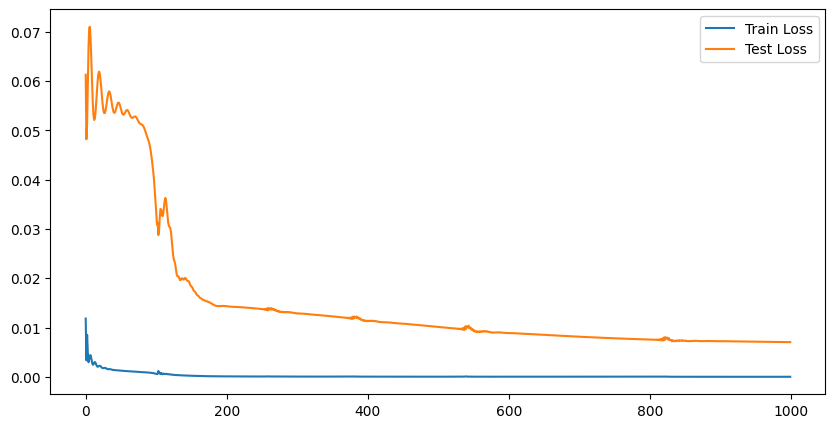

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.show()


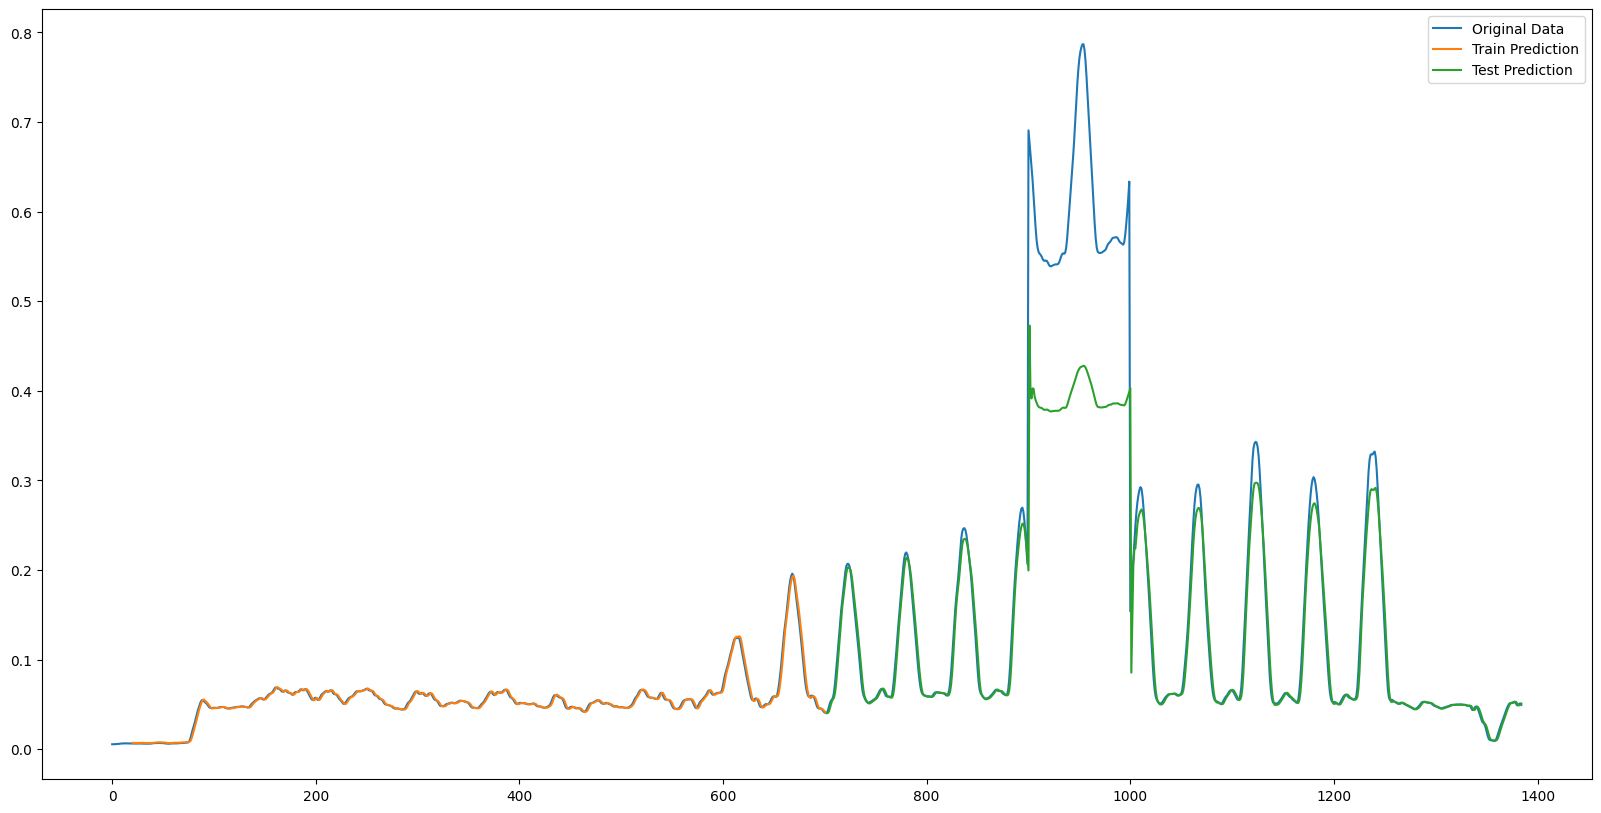

In [13]:
model.eval()
with torch.no_grad():
    output = model(train_data.unsqueeze(-1).to(device)).cpu().numpy()
    prediction = model(test_data.unsqueeze(-1).to(device)).cpu().numpy()

plt.figure(figsize=(20, 10))
plt.plot(dataT, label="Original Data")
plt.plot(range(window, len(output) + window), output[:, -1, :], label="Train Prediction")
plt.plot(range(window + len(output), len(output) + len(prediction) + window), prediction[:, -1, :], label="Test Prediction")
plt.legend()
plt.show()

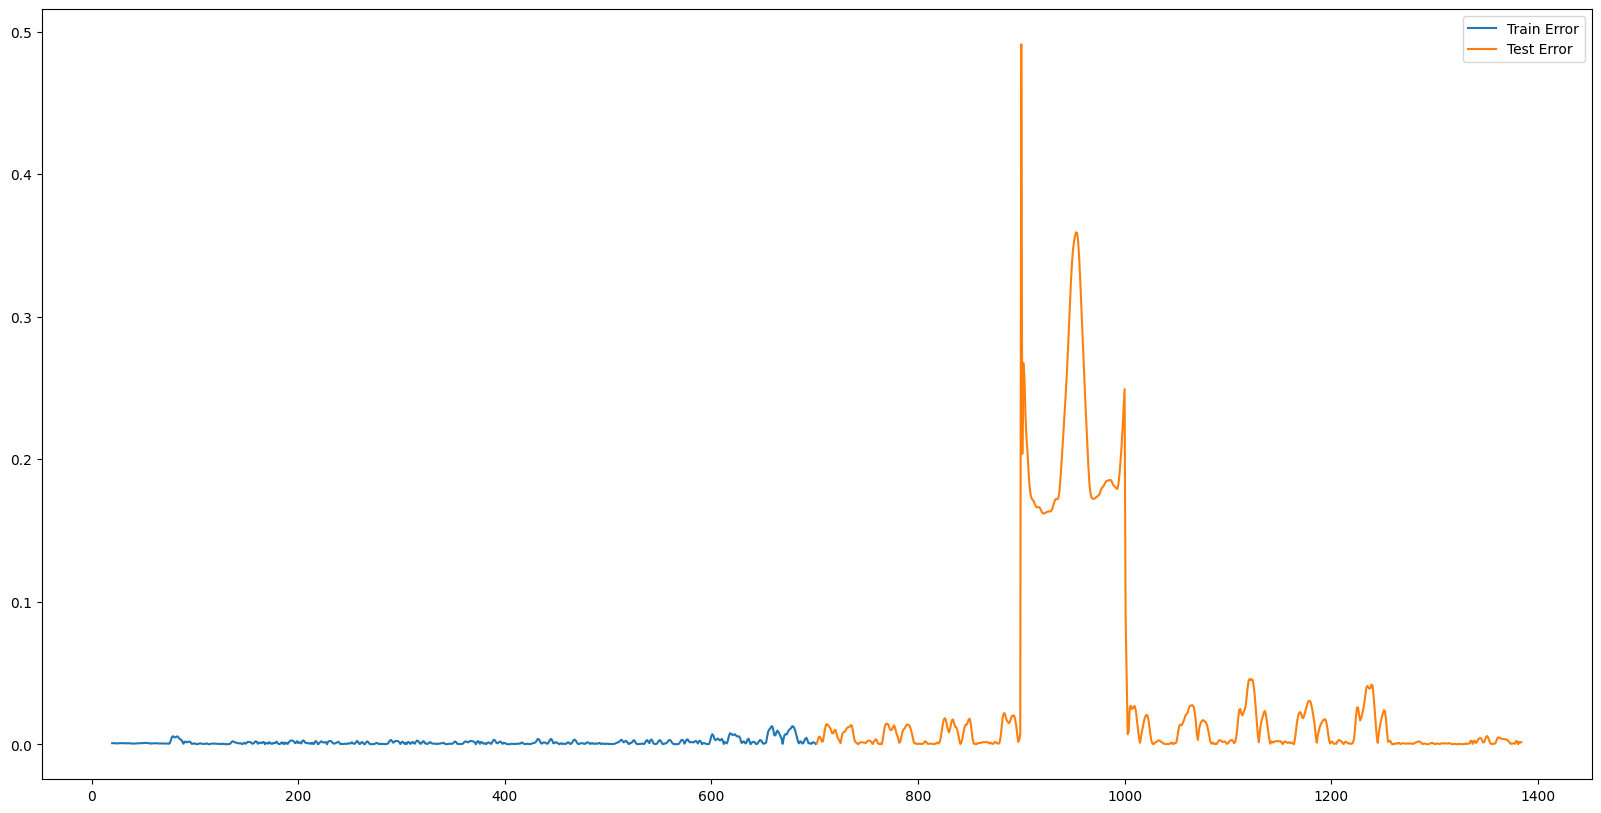

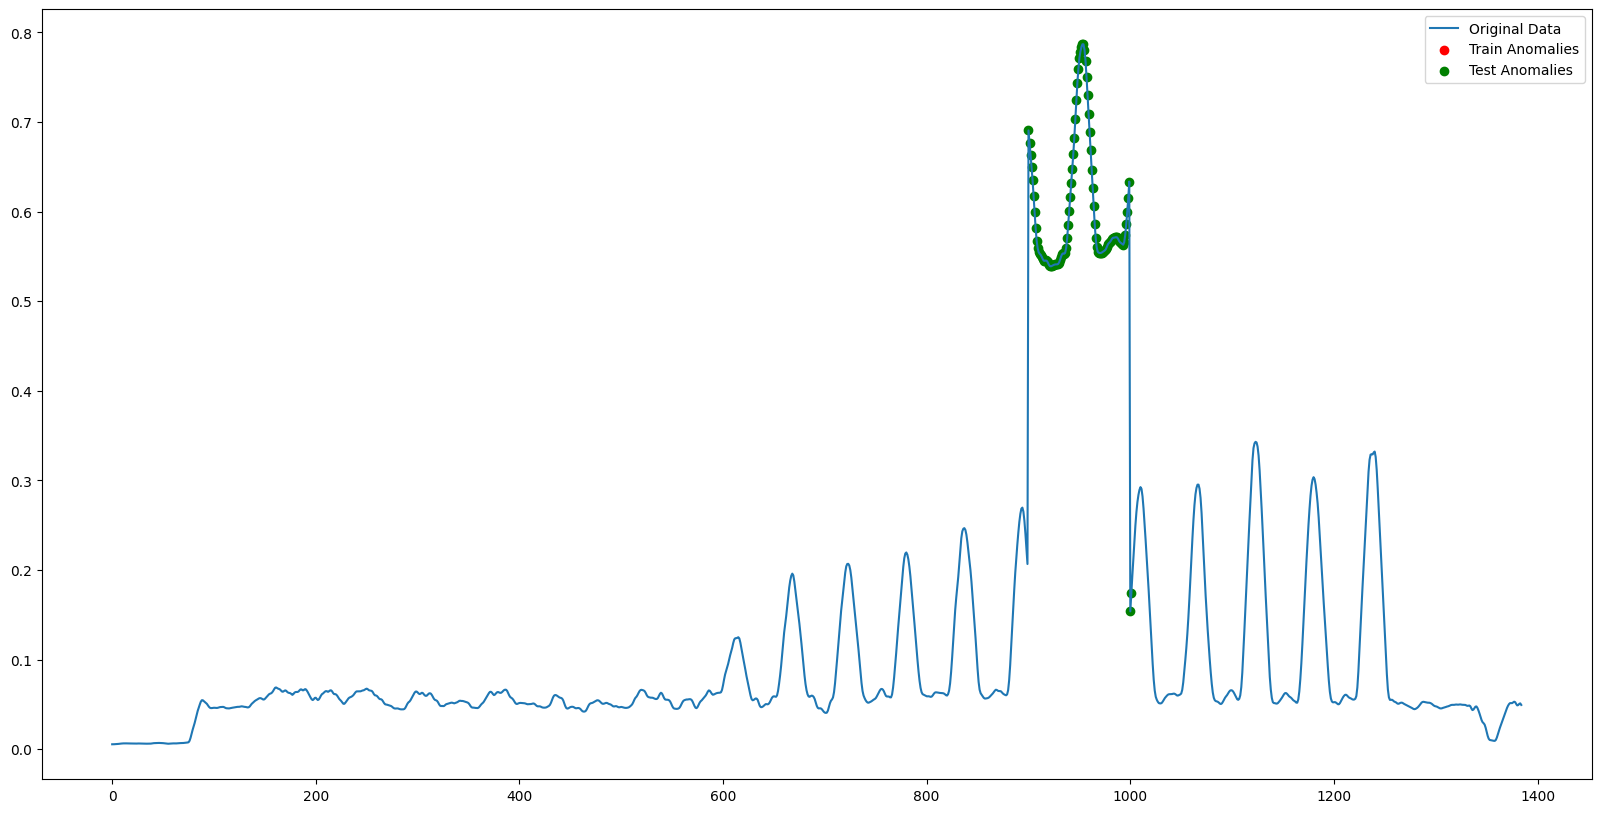

In [14]:
error_train = np.abs(output[:, -1, :].flatten() - dataT[window:train_size+window].numpy())
error_prediction = np.abs(prediction[:, -1, :].flatten() - dataT[train_size+window:].numpy())

plt.figure(figsize=(20, 10))
plt.plot(range(window, train_size+window), error_train, label="Train Error")
plt.plot(range(train_size+window, len(dataT)), error_prediction, label="Test Error")
plt.legend()
plt.show()
# plt.figure(figsize=(20, 10))
# plt.plot(error, label="Error")
# plt.legend()

error_train.shape, error_prediction.shape

threshold = .05 
anomalies_train = np.where(error_train > threshold)[0]
anomalies_prediction = np.where(error_prediction > threshold)[0]

plt.figure(figsize=(20, 10))
plt.plot(dataT, label="Original Data")
plt.scatter(anomalies_train + window, dataT[anomalies_train + window], color='r', label="Train Anomalies")
plt.scatter(anomalies_prediction + window + train_size, dataT[anomalies_prediction + window + train_size], color='g', label="Test Anomalies")
plt.legend()
plt.show()

torch.Size([682, 20])